import torch
import numpy
import pandas

In [17]:
import torch
import numpy as np
import pandas

In [18]:
import gc

gc.collect()

torch.cuda.empty_cache()

In [19]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Feb 25 20:12:41 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   29C    P0             43W /  400W |       5MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [20]:
from dataclasses import dataclass

@dataclass
class TrainingConfig:
    image_size = 128  # the generated image resolution
    train_batch_size = 16
    eval_batch_size = 16 # how many images to sample during evaluation
    num_epochs = 10
    gradient_accumulation_steps = 1
    learning_rate = 1e-4
    lr_warmup_steps = 500
    save_image_epochs = 10
    save_model_epochs = 10
    mixed_precision = "fp16"  # `no` for float32, `fp16` for automatic mixed precision
    output_dir = "emoji"  # the model name locally and on the HF Hub
    seed = 0


config = TrainingConfig()

In [21]:
!pip install datasets

In [22]:
from datasets import load_dataset

config.dataset_name = "valhalla/emoji-dataset"
if torch.cuda.is_available():
    config.device = "cuda"
else:
    config.device = "cpu"
dataset = load_dataset("valhalla/emoji-dataset", split="train")

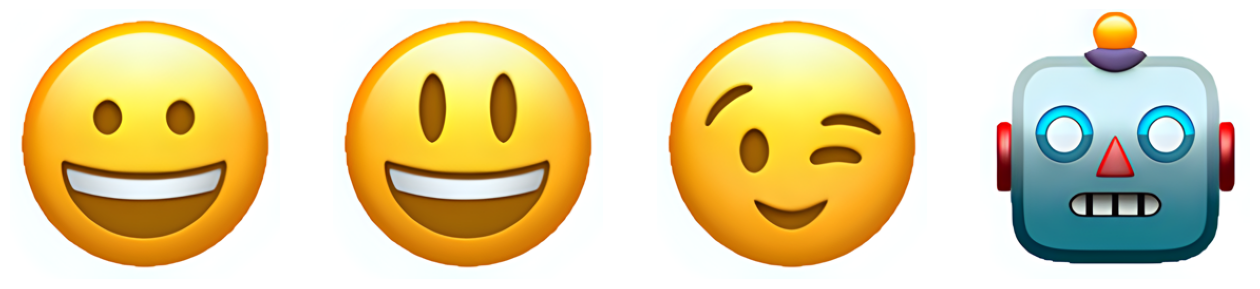

In [23]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 4, figsize=(16, 4))

for i, image in enumerate(dataset[:4]["image"]):
  axs[i].imshow(image)
  axs[i].set_axis_off()
fig.show()

In [24]:
from torchvision import transforms

preprocess = transforms.Compose(
    [
        transforms.Resize((128, 128)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
    ]
)

In [25]:
def transform(examples):
    images = [preprocess(image.convert("RGB")) for image in examples["image"]]
    return {"images": images}


dataset.set_transform(transform)

In [26]:
import torch

train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=config.train_batch_size, shuffle=True)

In [27]:
from diffusers import UNet2DModel

model = UNet2DModel(
    sample_size=config.image_size,  # the target image resolution
    in_channels=3,  # the number of input channels, 3 for RGB images
    out_channels=3,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(128, 128, 256, 256, 512, 512),  # the number of output channels for each UNet block
    down_block_types=(
        "DownBlock2D",  # a regular ResNet downsampling block
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "DownBlock2D",
    ),
    up_block_types=(
        "UpBlock2D",  # a regular ResNet upsampling block
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
    ),
)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [28]:
sample_image = dataset[0]["images"].unsqueeze(0)
print("Input shape:", sample_image.shape)

Input shape: torch.Size([1, 3, 128, 128])


In [15]:
print("Output shape:", model(sample_image, timestep=0).sample.shape)

Output shape: torch.Size([1, 3, 128, 128])


(-0.5, 127.5, 127.5, -0.5)

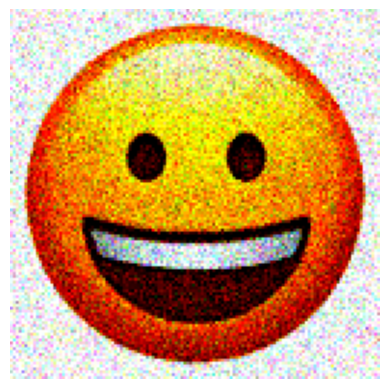

In [29]:
from posix import times
from diffusers import DDPMScheduler

noise_scheduler = DDPMScheduler(num_train_timesteps=1000)
noise = torch.randn(sample_image.shape)
timesteps = torch.LongTensor([50])
noisy_image = noise_scheduler.add_noise(sample_image, noise, timesteps)
plt.imshow(noisy_image[0].permute(1, 2, 0))
plt.axis("off")

In [32]:
import torch.nn.functional as F

noise_pred = model(noisy_image, timesteps).sample
loss = F.mse_loss(noise_pred.reshape(-1), noise.reshape(-1))
print("Loss:", loss.item())
noise_pred

Loss: 1.3339461088180542


tensor([[[[-0.2963, -0.2627, -0.1161,  ..., -0.0234, -0.0434, -0.3323],
          [-0.3645, -0.4410, -0.6409,  ..., -0.2261,  0.1058, -0.3868],
          [-0.3489, -0.5549, -0.6045,  ..., -0.2224, -0.0711, -0.3056],
          ...,
          [-0.7657, -0.5364, -0.6308,  ..., -0.0949, -0.1114, -0.3378],
          [-0.4840, -0.4264, -0.4475,  ..., -0.1873, -0.1700, -0.3872],
          [-0.2406, -0.2788, -0.3327,  ...,  0.1528,  0.0978, -0.0773]],

         [[-0.5844, -0.7003, -0.6929,  ..., -0.3810, -0.5011, -0.0202],
          [-0.7402, -1.1332, -1.3401,  ..., -0.8995, -0.6529, -0.3337],
          [-0.5683, -0.8866, -1.2045,  ..., -1.1068, -0.6895, -0.6419],
          ...,
          [-0.4567, -0.8745, -1.0344,  ..., -1.1908, -0.9206, -0.8397],
          [-0.1085, -0.7447, -0.8388,  ..., -0.8644, -0.6759, -0.6570],
          [ 0.1401, -0.0161, -0.2453,  ..., -0.3445, -0.1617, -0.3452]],

         [[ 0.0190,  0.1352,  0.0907,  ...,  0.1116,  0.1526,  0.1790],
          [ 0.3755,  0.3317,  

In [33]:
from diffusers.optimization import get_cosine_schedule_with_warmup

optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate)
lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=config.lr_warmup_steps,
    num_training_steps=(len(train_dataloader) * config.num_epochs),
)

In [34]:
from accelerate import Accelerator
from tqdm.auto import tqdm
import os

def train_loop(config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler):
    accelerator = Accelerator(
        mixed_precision=config.mixed_precision,
        gradient_accumulation_steps=config.gradient_accumulation_steps,
        log_with=["tensorboard"],
        project_dir=os.path.join(config.output_dir, "logs"),
    )

    model, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
        model, optimizer, train_dataloader, lr_scheduler
    )

    global_step = 0

    for epoch in range(config.num_epochs):
        progress_bar = tqdm(total=len(train_dataloader), disable=not accelerator.is_local_main_process)
        if accelerator.is_local_main_process:
            progress_bar.set_description(f"Epoch {epoch+1}/{config.num_epochs}")

        running_loss = 0.0
        num_batches = 0

        for step, batch in enumerate(train_dataloader):
            clean_images = batch["images"]
            noise = torch.randn(clean_images.shape).to(clean_images.device)
            bs = clean_images.shape[0]
            timesteps = torch.randint(
                0, noise_scheduler.config.num_train_timesteps, (bs,),
                device=clean_images.device, dtype=torch.long
            )
            noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

            with accelerator.accumulate(model):
                output = model(noisy_images, timesteps, return_dict=True)
                noise_pred = output.sample
                loss = F.mse_loss(noise_pred, noise)
                accelerator.backward(loss)

                accelerator.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()

            running_loss += loss.detach().item()
            num_batches += 1

            # Only include loss in the logs
            logs = {"loss": loss.detach().item()}
            if accelerator.is_local_main_process:
                progress_bar.set_postfix(**logs)
            accelerator.log(logs, step=global_step)
            global_step += 1
            if accelerator.is_local_main_process:
                progress_bar.update(1)

        accelerator.wait_for_everyone()

        # Only print on main process
        avg_loss = running_loss / num_batches
        accelerator.print(f"Epoch {epoch+1}/{config.num_epochs} - Average Loss: {avg_loss:.4f}")

        if accelerator.is_main_process:
            if (epoch + 1) % config.save_model_epochs == 0 or epoch == config.num_epochs - 1:
                # Save a checkpoint of the model state.
                checkpoint_path = os.path.join(config.output_dir, f"checkpoint-{epoch}")
                accelerator.save_state(checkpoint_path)
                print(f"Saved checkpoint at {checkpoint_path}")

In [35]:
config.logging_dir = "./logs"
config.output_dir = "./results"
train_loop(config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler)

  0%|          | 0/172 [00:00<?, ?it/s]

Epoch 1/10 - Average Loss: 0.3888


  0%|          | 0/172 [00:00<?, ?it/s]

Epoch 2/10 - Average Loss: 0.0549


  0%|          | 0/172 [00:00<?, ?it/s]

Epoch 3/10 - Average Loss: 0.0380


  0%|          | 0/172 [00:00<?, ?it/s]

Epoch 4/10 - Average Loss: 0.0289


  0%|          | 0/172 [00:00<?, ?it/s]

Epoch 5/10 - Average Loss: 0.0204


  0%|          | 0/172 [00:00<?, ?it/s]

Epoch 6/10 - Average Loss: 0.0194


  0%|          | 0/172 [00:00<?, ?it/s]

Epoch 7/10 - Average Loss: 0.0161


  0%|          | 0/172 [00:00<?, ?it/s]

Epoch 8/10 - Average Loss: 0.0153


  0%|          | 0/172 [00:00<?, ?it/s]

Epoch 9/10 - Average Loss: 0.0138


  0%|          | 0/172 [00:00<?, ?it/s]

Epoch 10/10 - Average Loss: 0.0151
Saved checkpoint at ./results/checkpoint-9


In [69]:
from torchvision.utils import make_grid

def inference(config, model, noise_scheduler, epoch, device, generator):
    eval_size = 64

    # Sample gaussian noise to begin loop
    image = torch.randn(
        (eval_size, model.in_channels, config.image_size, config.image_size),
        generator=generator,
    )
    image = image.to(device)

    # set step values
    noise_scheduler.set_timesteps(1000)

    with torch.no_grad():
      for t in tqdm(noise_scheduler.timesteps, desc="Processing timesteps"):
          # 1. predict noise model_output
          model_output = model(image, t).sample

          # 2. compute previous image: x_t -> t_t-1
          image = noise_scheduler.step(model_output, t, image, generator=generator).prev_sample

    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.cpu().permute(0, 2, 3, 1).numpy()

    return image

In [70]:
from safetensors.torch import load_file, load_model

device = ("cuda" if torch.cuda.is_available() else "cpu")

# model trained with 50 epochs
load_model(model, "model.safetensors")

image = inference(config, model, noise_scheduler, 50, device, generator=torch.Generator(device='cpu').manual_seed(config.seed))

<ipython-input-69-49f4e027634d>:8: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DModel's config object instead, e.g. 'unet.config.in_channels'.
  (eval_size, model.in_channels, config.image_size, config.image_size),


Processing timesteps:   0%|          | 0/1000 [00:00<?, ?it/s]

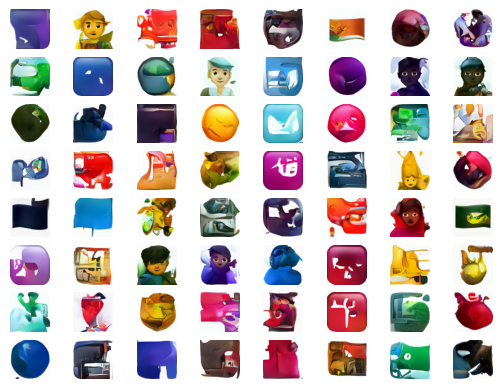

In [71]:
for i in range(64):
    plt.subplot(8, 8, i + 1)
    plt.imshow(image[i])
    plt.axis('off')

In [72]:
# do additional 10 epochs training (model already trained in 50 epochs before)

config.logging_dir = "./logs"
config.output_dir = "./results"
train_loop(config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler)

  0%|          | 0/172 [00:00<?, ?it/s]

Epoch 1/10 - Average Loss: 0.0084


  0%|          | 0/172 [00:00<?, ?it/s]

Epoch 2/10 - Average Loss: 0.0079


  0%|          | 0/172 [00:00<?, ?it/s]

Epoch 3/10 - Average Loss: 0.0083


  0%|          | 0/172 [00:00<?, ?it/s]

Epoch 4/10 - Average Loss: 0.0086


  0%|          | 0/172 [00:00<?, ?it/s]

Epoch 5/10 - Average Loss: 0.0090


  0%|          | 0/172 [00:00<?, ?it/s]

Epoch 6/10 - Average Loss: 0.0092


  0%|          | 0/172 [00:00<?, ?it/s]

Epoch 7/10 - Average Loss: 0.0100


  0%|          | 0/172 [00:00<?, ?it/s]

Epoch 8/10 - Average Loss: 0.0088


  0%|          | 0/172 [00:00<?, ?it/s]

Epoch 9/10 - Average Loss: 0.0092


  0%|          | 0/172 [00:00<?, ?it/s]

Epoch 10/10 - Average Loss: 0.0089
Saved checkpoint at ./results/checkpoint-9


<ipython-input-69-49f4e027634d>:8: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DModel's config object instead, e.g. 'unet.config.in_channels'.
  (eval_size, model.in_channels, config.image_size, config.image_size),


Processing timesteps:   0%|          | 0/1000 [00:00<?, ?it/s]

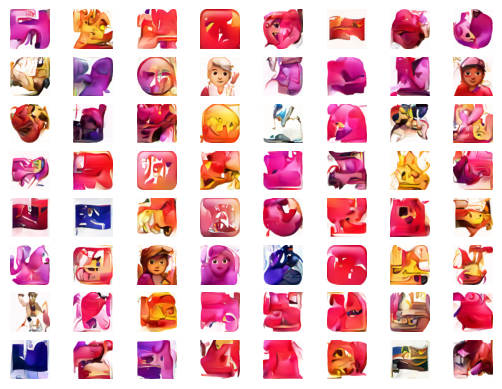

In [73]:
image = inference(config, model, noise_scheduler, 50, device, generator=torch.Generator(device='cpu').manual_seed(config.seed))

for i in range(64):
    plt.subplot(8, 8, i + 1)
    plt.imshow(image[i])
    plt.axis('off')

In [74]:
# model trained with 50 epochs
load_model(model, "model.safetensors")

image = inference(config, model, noise_scheduler, 50, device, generator=torch.Generator(device='cpu').manual_seed(config.seed))

<ipython-input-69-49f4e027634d>:8: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DModel's config object instead, e.g. 'unet.config.in_channels'.
  (eval_size, model.in_channels, config.image_size, config.image_size),


Processing timesteps:   0%|          | 0/1000 [00:00<?, ?it/s]

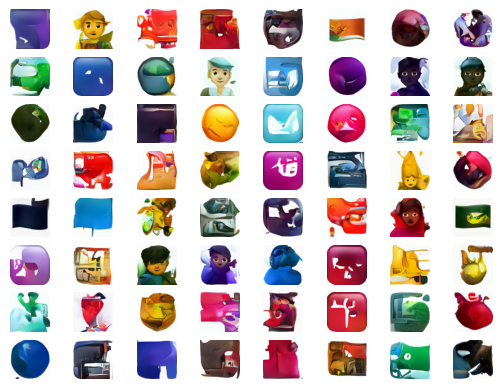

In [75]:

for i in range(64):
    plt.subplot(8, 8, i + 1)
    plt.imshow(image[i])
    plt.axis('off')

<ipython-input-69-49f4e027634d>:8: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DModel's config object instead, e.g. 'unet.config.in_channels'.
  (eval_size, model.in_channels, config.image_size, config.image_size),


Processing timesteps:   0%|          | 0/1000 [00:00<?, ?it/s]

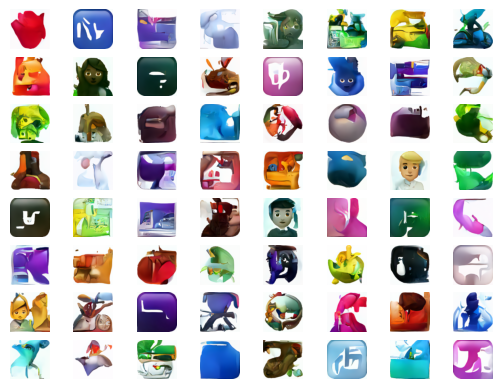

In [76]:
new_image = inference(config, model, noise_scheduler, 50, device, generator=torch.Generator(device='cpu').manual_seed(17))

for i in range(64):
    plt.subplot(8, 8, i + 1)
    plt.imshow(new_image[i])
    plt.axis('off')